# Short-time Fourier Transform
on audio files

STFT is a DFT on defined time spans

## Load audio files

In [1]:
import os
from sklearn import datasets

PARAM_RND_STATE = 42

container_path = os.path.join ('..', '..', 'src_audio')
load_content = False
description = ['key C, mode minor', 'key C, mode major',
               'key C#, mode minor', 'key C#, mode major',
               'key D, mode minor', 'key D, mode major',
               'key D#, mode minor', 'key D#, mode major',
               'key E, mode minor', 'key E, mode major',
               'key F, mode minor', 'key F, mode major',
               'key F#, mode minor', 'key F#, mode major',
               'key G, mode minor', 'key G, mode major',
               'key G#, mode minor', 'key G#, mode major',
               'key A, mode minor', 'key A, mode major',
               'key A#, mode minor', 'key A#, mode major',
               'key B, mode minor', 'key B, mode major']

src_audio_data = datasets.load_files (container_path=container_path,
                                      description=description,
                                      load_content=load_content,
                                      random_state=PARAM_RND_STATE)

/home/ubudan/ml/keyestcnn/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubudan/ml/keyestcnn/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubudan/ml/keyestcnn/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubudan/ml/keyestcnn/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
src_audio_data.keys ()

dict_keys(['target', 'filenames', 'DESCR', 'target_names'])

## Prepare audio files and perform FFT

### Function definitions
<a href='https://docs.scipy.org/doc/scipy/reference/signal.html'>https://docs.scipy.org/doc/scipy/reference/signal.html</a>

<a href='https://stackoverflow.com/questions/604453/analyze-audio-using-fast-fourier-transform'>https://stackoverflow.com/questions/604453/analyze-audio-using-fast-fourier-transform</a>

<a href='https://stackoverflow.com/questions/18248102/removal-of-dc-offset-using-highpass-fft-filter'>https://stackoverflow.com/questions/18248102/removal-of-dc-offset-using-highpass-fft-filter</a>


explanation of signal data:
- *sig_fs* = sampling rate (samples per second)
- *sig_ch* = number of channels
- *sig_N* = number of samples
- *sig_nw* = sample width (bytes)
- *sig_len* = length of signal (seconds)
- *sig* = signal data (array of samples)

In [3]:
# ----- read audio signal
from scipy.io import wavfile

def read_audio_signal (filename):
    print ('>>> reading audio file...', end=' ', flush=True)
    sig_fs, sig = wavfile.read (filename)
    print ('done')
    
    return sig_fs, sig


# ----- signal preparation
from scipy import signal

PARAM_DEC_FAC = 2 # PARAM: decimation factor
def prepare_signal (sig_fs, sig):
    sig_prep = np.copy (sig)
    
    print ('>>> reducing signal to one channel...', end=' ', flush=True)
    sig_ch = len (sig.shape)
    if sig_ch == 2:
        sig_prep = sig_prep.sum (axis=1) / 2
    print ('done')
    
    print ('>>> decimation of signal to (factor {})...'.format (PARAM_DEC_FAC), end=' ', flush=True)
    sig_prep = signal.decimate (sig_prep, q=PARAM_DEC_FAC, ftype='fir').astype (dtype=sig.dtype, copy=False)
    print ('done')
    
    return int (sig_fs/PARAM_DEC_FAC), sig_prep


# ----- slice signal in parts where number of samples are to the power of 2
import math
import numpy as np

PARAM_N = 1<<13 # PARAM: number of samples for one dft
def slice_signal (sig):
    print ('>>> slicing signal...', end=' ', flush=True)
    sig_N = sig.shape[0]
    num_slices = math.floor (sig_N / PARAM_N)
    if (num_slices*PARAM_N < sig_N):  # one more slice usually needed -> checked here
        num_slices += 1
    sig_slices = np.empty ((num_slices, PARAM_N))

    for i in range (num_slices):
        sl = np.copy (sig)[i*PARAM_N:(i+1)*PARAM_N]
        # only last slice of source signal will differ in length
        if (i == (num_slices-1)):
            num_zeros = PARAM_N-sl.size
            sl = np.append (sl, np.full (num_zeros, 0, dtype=sl.dtype))
    
        sig_slices[i] = sl
    print ('done')
    print ('  [i] signal sliced in {} parts, each {} samples.'.format (sig_slices.shape[0], sig_slices.shape[1]))
    
    return sig_slices


# ----- windowing signal (Hanning window is used)
import numpy as np
from scipy import signal

PARAM_WIN = signal.hann (PARAM_N) # PARAM: type of window
def window_signal (sig_slices):
    sig_slices_win = np.copy (sig_slices)
    print ('>>> windowing signal...', end=' ', flush=True)
    for i in range (sig_slices_win.shape[0]):
        sig_slices_win[i] = sig_slices_win[i]*PARAM_WIN
    print ('done')
    
    return sig_slices_win


# ----- zero-padding of signal
# number of samples of the time-domain signal dictate the resolution in the frequency-domain
import numpy as np

PARAM_N_ZEROS = 1<<13 # PARAM: number of zeros to add
def zpad_signal (sig_slices):
    print ('>>> zero-padding signal...', end=' ', flush=True)
    sig_slices_zpad = np.empty ((sig_slices.shape[0], sig_slices.shape[1]+PARAM_N_ZEROS))
    for i in range (sig_slices.shape[0]):
        sig_slices_zpad[i] = np.append (sig_slices[i], np.full (PARAM_N_ZEROS, 0, dtype=sig_slices[i].dtype))
    print ('done')
    print ('  [i] new shape of signal slice', sig_slices_zpad.shape)
    
    return sig_slices_zpad


# ----- discrete Fourier transform
import numpy as np
import scipy
import scipy.fftpack

def dft_signal (sig_fs, sig_slices):
    print ('>>> performing Fourier transformation...', end=' ', flush=True)
    # retrieve Fourier Transform coefficients
    # calculate magnitude of the FFT coefficients (= absolute value of each complex coefficient)
    sig_fft_mags = np.empty (sig_slices.shape)
    for i in range (sig_slices.shape[0]):
        sig_fft_mags[i] = abs (scipy.fft (sig_slices[i]))

    # get the frequency bin centers in cycles per unit of the sample spacing (with zero at the start)
    freq_bins = list (range (0, len (sig_fft_mags[0])))
    # convert bins to frequency range
    freq_bins_f = (np.array (freq_bins)/len(sig_fft_mags[0])) * sig_fs
    print ('done')
    
    return sig_fft_mags, freq_bins_f

/home/ubudan/ml/keyestcnn/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Twelve-tone equal temperament (12TET)
- used to pack the dft magnitudes into bins of pitch ranges

In [4]:
# ----- pitch frequencies of 12 tone equal temperament
import numpy as np

pitch_A0 = 27.5
pitch_Ax = np.array ([pitch_A0*(2**n) for n in range (-1, 11)])
twtet_pitch_ratios = np.array ([2**(n*1/12) for n in range (-9, 3)])

twtet_pitches = np.empty ((11,12)) # shape is 11 octaves, each 12 pitches
for i in range (11):
    twtet_pitches[i] = pitch_Ax[i] * twtet_pitch_ratios

twtet_pitches = twtet_pitches.flatten ()
# MIDI notation has only 128 numbers
#twtet_pitches = twtet_pitches[:128]

# we take only 108 pitches (extended piano)
#pitch_C0_midi = 12
#twtet_pitches = twtet_pitches[pitch_C0_midi:120]

# only take 88 pitches (standard piano)
pitch_A0_midi = 21
pitch_C8_midi = 108
twtet_pitches = twtet_pitches[pitch_A0_midi:pitch_C8_midi+1]

print ('  [i] 12-TET pitches')
print ('    count:', twtet_pitches.size)
print ('    example: A4= {} Hz'.format (twtet_pitches[69-pitch_A0_midi]))

  [i] 12-TET pitches
    count: 88
    example: A4= 440.0 Hz


### Function definition - spectrogram
output: 2dim numpy array with values in range [0, 255] (image bit range)

dimension of an image = (sig_slices, twet_pitches), if sig_slices < twet_pitches, then zeros are appended

[i] dim sig_slices = dim sig_fft_mags

In [5]:
# ----- make and save image
import matplotlib.pyplot as plt
%matplotlib inline

def create_spectrogram (sig_fft_mags, freq_bins_f):
    print ('>>> creating spectorgram...', end=' ', flush=True)
    spectro = np.zeros (twtet_pitches.shape[0]-1)
    # get only some values of the fft magnitudes
    n_fft_mags = 1<<5
    for i in range (sig_fft_mags.shape[0]):
        cpy = np.copy (sig_fft_mags[i])
        freq_list = []
        for _ in range (n_fft_mags):
            bin_n = np.argmax (cpy)
            freq_list.append (freq_bins_f[bin_n])
            cpy = np.delete (cpy, bin_n)
        hist, edges = np.histogram (freq_list, bins=twtet_pitches, range=(twtet_pitches.min(), twtet_pitches.max()))
        # convert to bit scale [0, 255]
        max_val = hist.max ()
        if (max_val == 0):
            spectro = np.vstack ((spectro, hist))
            continue
        hist = int (255 / max_val) * hist
        spectro = np.vstack ((spectro, hist))
    # append zeros
    if (sig_fft_mags.shape[0] < spectro.shape[1]):
        num_zeros = spectro.shape[1] - sig_fft_mags.shape[0]
        spectro = np.vstack ((spectro, np.zeros ((num_zeros, spectro.shape[1]))))
    print ('done')
    
    return np.delete (spectro, 0, axis=0) # due to init empty array + vstack, first row can be deleted

In [6]:
import os
from PIL import Image

save_path = os.path.join ('..', '..', 'src_spectro')
for i, filename in enumerate (src_audio_data['filenames']):
    print ('\rprocessing {} of {} audio files'.format (i+1, src_audio_data['filenames'].shape[0]), end='\n')

    sig_fs, sig = read_audio_signal (filename)

    sig_prep_fs, sig_prep = prepare_signal (sig_fs, sig)

    sig_prep_slices = slice_signal (sig_prep)
    
    # special windowing currently unused (that means, rectangular window is used)
    #sig_prep_slices_win = window_signal (sig_prep_slices)

    sig_prep_slices_zpad = zpad_signal (sig_prep_slices)

    sig_fft_mags, freq_bins_f = dft_signal (sig_prep_fs, sig_prep_slices_zpad)

    base_name, _ = os.path.splitext(os.path.basename (filename))
    target_name = src_audio_data['target_names'][src_audio_data['target'][i]]
    save_as = os.path.join (save_path, target_name, base_name + '.png')
    spectro = create_spectrogram (sig_fft_mags, freq_bins_f)

    # ----- edit images: convert to 8 Bit and rotate by 90 degrees
    base_name, _ = os.path.splitext(os.path.basename (filename))
    target_name = src_audio_data['target_names'][src_audio_data['target'][i]]
    save_as = os.path.join (save_path, target_name, base_name + '.png')
    print ('>>> rotating and saving image as {} ...'.format (save_as), end=' ', flush=True)
    img = Image.fromarray (spectro)
    #img = img.resize (size, Image.NEAREST)
    #size = (spectro.shape[1], spectro.shape[1])
    img = img.rotate (90)
    img = img.convert('RGB')
    img.save (save_as)
    print ('done')

processing 1 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... 

/home/ubudan/ml/keyestcnn/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/ubudan/ml/keyestcnn/lib/python3.5/site-packages/scipy/signal/signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
/home/ubudan/ml/keyestcnn/lib/python3.5/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


done
>>> rotating and saving image as ../../src_spectro/1-0/TRLZZOJ128F1494C12.png ... done
processing 2 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/0-0/TRUXMRH128F92F7A43.png ... done
processing 3 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spec

>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/5-1/TRDADBO128C7196C2E.png ... done
processing 20 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/4-0/TRKCHCP128F42187D5.png ... done
processing 21 of 240 audio files
>>> reading audio file... done
>>> reducing signal

>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/11-0/TRYGIDP12903CE1349.png ... done
processing 37 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/7-1/TRCLCNP128F4274E6C.png ... done
processing 38 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in

>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/8-0/TRWIPVP128F4260CBC.png ... done
processing 54 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/7-1/TRHFEEP12903CD3863.png ... done
processing 55 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> 

>>> rotating and saving image as ../../src_spectro/7-1/TRIKNPG128E0792FF0.png ... done
processing 71 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/6-1/TRUKEMP128F9336618.png ... done
processing 72 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro

>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/1-1/TRNMTSE128F428461A.png ... done
processing 89 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/1-0/TRUBEOU128F422E200.png ... done
processing 90 of 240 audio files
>>> reading audio file... done
>>> reducing signal

>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/8-1/TRPMZQC128F14693DA.png ... done
processing 106 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/9-1/TRWNOXZ12903CDB377.png ... done
processing 107 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>

>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/5-0/TRBYATZ128F4254F0A.png ... done
processing 123 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/11-0/TREDEZC128F92E3D83.png ... done
processing 124 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape

>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/4-1/TRLOXSL128F1484144.png ... done
processing 140 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/4-0/TRTJSBZ128F426A23B.png ... done
processing 141 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>

>>> rotating and saving image as ../../src_spectro/10-0/TRRWZDM128F930DAB7.png ... done
processing 157 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/2-1/TRRCPXP128E0791F01.png ... done
processing 158 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spec

>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/6-1/TRICVEC128E078B063.png ... done
processing 175 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/3-1/TRBGRIP128F147FCA6.png ... done
processing 176 of 240 audio files
>>> reading audio file... done
>>> reducing sign

>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/7-1/TRNIWUC128F4284F76.png ... done
processing 192 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/9-0/TRAKXUV128F9301F49.png ... done
processing 193 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>

>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/10-1/TRZJVRP128F93069BD.png ... done
processing 209 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/8-0/TRHQWMN128F426AB93.png ... done
processing 210 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape

>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/3-1/TRUVVTE12903CC6E5B.png ... done
processing 226 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done
>>> rotating and saving image as ../../src_spectro/2-0/TRVPKML128F427AA59.png ... done
processing 227 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>

## Example

In [14]:
import os

save_path = os.path.join ('..', '..', 'src_spectro')
filename = src_audio_data['filenames'][46]


sig_fs, sig = read_audio_signal (filename)

sig_prep_fs, sig_prep = prepare_signal (sig_fs, sig)

sig_prep_slices = slice_signal (sig_prep)

#sig_prep_slices_win = window_signal (sig_prep_slices)

sig_prep_slices_zpad = zpad_signal (sig_prep_slices)

sig_fft_mags, freq_bins_f = dft_signal (sig_prep_fs, sig_prep_slices_zpad)

spectro = create_spectrogram (sig_fft_mags, freq_bins_f)

>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
  [i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> creating spectorgram... done


/home/ubudan/ml/keyestcnn/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/ubudan/ml/keyestcnn/lib/python3.5/site-packages/scipy/signal/signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
/home/ubudan/ml/keyestcnn/lib/python3.5/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


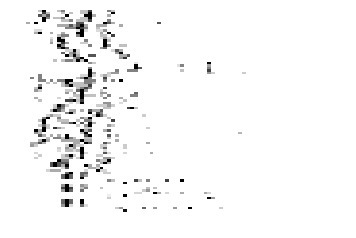

In [15]:
fig, axs = plt.subplots (1, 1, sharex=True)
extent = [0, twtet_pitches.size, 0, 1]
axs.imshow (spectro, aspect='auto', cmap="binary", extent=extent)
axs.axis ('off')
axs.axes.get_xaxis().set_visible (False)
axs.axes.get_yaxis().set_visible (False)

plt.show ()

[i] Example
signal information:
  channels: 2
  sampling rate: 44100 Hz (S/s)
  number of samples: 1323000 S
  sample width: 2 Bytes = 16 Bits
  length of signal: 30.00 s


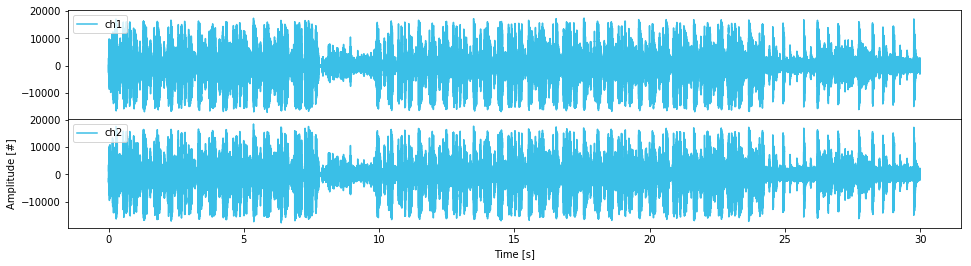

In [16]:
# FYI: EXAMPLE
import matplotlib.pyplot as plt
%matplotlib inline

print ('[i] Example')

sig_ch = len (sig.shape) # number of channels
sig_N = sig.shape[0] # number of samples
sig_nw = sig.dtype.itemsize # sample width
sig_len = sig_N/sig_fs # length of signal

print ('signal information:')
print ('  channels:', sig_ch)
print ('  sampling rate: {} Hz (S/s)'.format (sig_fs))
print ('  number of samples: {} S'.format (sig_N))
print ('  sample width: {} Bytes = {} Bits'.format (sig_nw, sig_nw*8))
print ('  length of signal: {:.2f} s'.format (sig_len))


# plot sample of wav file
t = np.linspace (0, len (sig)/sig_fs, sig_N)

fig, axs = plt.subplots (2, 1, sharex=True, sharey=True)

axs[0].step (t, sig[:,0], c="#3ABFE7", label='ch1')
axs[0].legend (loc='upper left')

axs[1].step (t, sig[:,1], c="#3ABFE7", label='ch2')
axs[1].legend (loc='upper left')

_ = plt.ylim()
fig.set_size_inches ((16., 4.), forward=True)
fig.suptitle ('')
fig.subplots_adjust (hspace=0)

plt.xlabel('Time [s]')
plt.ylabel('Amplitude [#]')

plt.show()

[i] Example
signal information:
  channels: 1
  sampling rate: 22050 Hz (S/s)
  number of samples: 661500 S
  sample width: 2 Bytes = 16 Bits
  length of signal: 30.00 s


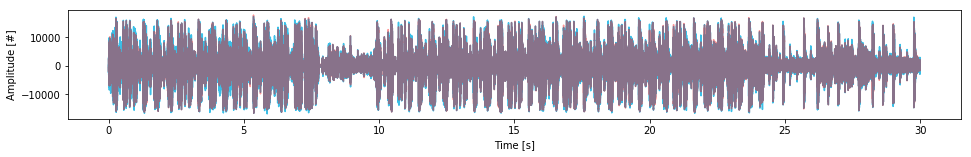

In [17]:
# FYI: EXAMPLE
print ('[i] Example')

sig_prep_ch = len (sig_prep.shape) # number of channels
sig_prep_N = sig_prep.shape[0] # number of samples
sig_prep_nw = sig_prep.dtype.itemsize # sample width
sig_prep_len = sig_prep_N/sig_prep_fs # length of signal

print ('signal information:')
print ('  channels:', sig_prep_ch)
print ('  sampling rate: {} Hz (S/s)'.format (sig_prep_fs))
print ('  number of samples: {} S'.format (sig_prep_N))
print ('  sample width: {} Bytes = {} Bits'.format (sig_prep_nw, sig_prep_nw*8))
print ('  length of signal: {:.2f} s'.format (sig_prep_len))

plt.figure(figsize=(16.,2.))
plt.step (t, sig[:, 0], c="#3ABFE7", label='src ch1')

t_prep = np.linspace (0, len (sig_prep)/sig_prep_fs, sig_prep_N)
plt.step (t_prep, sig_prep, c="#FF0000", alpha=0.4, label='mono')

plt.xlabel('Time [s]')
plt.ylabel('Amplitude [#]')

plt.show ()

---

## Short-Time Fourier Transformation (STFT)

## simple example for windowing

### cosine wave and its dft

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fs = 1000 # frames per second
T = 1/fs
N = 1000 # samples
n = list (range (0,N))
t = np.linspace (0, len (n)*T, N)
x = [math.cos (2*math.pi*6.5*_t) for _t in t] # cos with freq of 6.5 Hz

# -----

import scipy
import scipy.fftpack

x_zpad = np.append (x, np.full (99000, 0))
X_ZPAD_mags = abs (scipy.fft (x_zpad))
bins = list (range (0, len (x_zpad)))


# -----

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure (figsize=(16.,6.))
plt.subplot (211)
plt.plot (t, x)
plt.title ('time-domain signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [#]')
plt.grid (True)
plt.subplot (212)
plt.plot (bins[0:1500], X_ZPAD_mags[0:1500])
plt.title ('magnitude spectrum of zero-padded signal')
plt.xlabel ('Frequency bin [#]')
plt.ylabel ('Magnitude [#]')
plt.grid (True)

plt.subplots_adjust (hspace=0.5)
plt.show ()

above DFT magnitude spectrum plot shows the first 1500 bins

the frequency with highest magnitude is calculated by:

bin_num / len (x_zpad) \* fs = 650 / 100.000 \* 1.000 = 6.5 Hz

In [ ]:
# now bins will be converted to frequency range
import matplotlib.pyplot as plt
%matplotlib inline

fax = np.array (bins) * fs / len (x_zpad)

plt.figure (figsize=(16.,3.))
plt.plot (fax[0:1500], X_ZPAD_mags[0:1500])
plt.title ('magnitude spectrum of zero-padded signal')
plt.xlabel ('Frequency [Hz]')
plt.ylabel ('Magnitude [#]')
plt.grid (True)

plt.show ()

print ('frequency with highest magnitude = {} Hz'.format (fax[np.argmax(X_ZPAD_mags)]))

### rectangular window

first: look at signals in time-domain

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Ndisp = 5000

plt.figure (figsize=(16.,6.))
plt.subplot (311)
plt.plot (x_zpad[0:Ndisp])
plt.title ('zero-padded signal' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

t = np.linspace (0, 100000*T, 100000)
sinusoid = [math.cos (2*math.pi*6.5*_t) for _t in t] # cos with freq of 6.5 Hz
plt.subplot (312)
plt.plot (sinusoid[0:Ndisp])
plt.title ('sinusoidal signal' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

win = np.append (np.ones (1000), np.zeros (99000))
plt.subplot (313)
plt.plot (win[0:Ndisp])
plt.title ('rectangular window' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.ylim (-0.5, 1.5)
plt.grid (True)

plt.subplots_adjust (hspace=0.8)
plt.show ()

Interpretation of rectangular window: the sinusoidal signal (graph 2) is multiplied by the rectangular window (graph 3) in order to get the zero-padded signal (graph 1)

second: now let's see how the requency-domain looks like

In [ ]:
fax_dbl_sided = np.copy (fax)

fax_dbl_sided[-49999:] = fax_dbl_sided[-49999:]-1000


plt.figure (figsize=(16.,6.))
plt.subplot (311)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (x_zpad))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (x_zpad))[-1000:])
plt.title ('double-sided magnitude spectrum of zero-padded signal')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.figure (figsize=(16.,6.))
plt.subplot (312)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (sinusoid))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (sinusoid))[-1000:])
plt.title ('double-sided magnitude spectrum of sinusoidal signal')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

win = np.append (np.ones (1000), np.zeros (99000))
plt.subplot (313)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (win))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (win))[-1000:])
plt.title ('double-sided magnitude of rectangular window')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.subplots_adjust (hspace=0.8)
plt.show ()

As shown, the sinusoidal signal is in general just a line in frequency-domain. But due to the applied rectangular window in time-domain, the dft ends up like for the zero-padded signal.

Consequence: **Convolution** = multiplication in time-domain results in convolution in frequency-domain

### hanning window
same as above, nut now with hanning window

In [ ]:
### time-domain signals

from scipy import signal
import scipy.fftpack

import matplotlib.pyplot as plt
%matplotlib inline

Ndisp = 5000

# THIS IS THE IMPORTANT PART - multiply window with time-domain signal
han_win = signal.hann (N)
x_zpad_win = np.append (x*han_win, np.full (99000, 0))

plt.figure (figsize=(16.,6.))
plt.subplot (311)
plt.plot (x_zpad_win[0:Ndisp])
plt.title ('zero-padded signal' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

t = np.linspace (0, 100000*T, 100000)
sinusoid = [math.cos (2*math.pi*6.5*_t) for _t in t] # cos with freq of 6.5 Hz
plt.subplot (312)
plt.plot (sinusoid[0:Ndisp])
plt.title ('sinusoidal signal' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)


plt.subplot (313)
plt.plot (np.append (han_win, np.zeros (99000))[0:Ndisp])
plt.title ('hanning window' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.ylim (-0.5, 1.5)
plt.grid (True)

plt.subplots_adjust (hspace=0.8)
plt.show ()

sinusiodal signal is multiplied with hanning window to get the zero-padded signal (graph 1)

In [ ]:
# frequency-domain signals

from scipy import signal
import scipy.fftpack

import matplotlib.pyplot as plt
%matplotlib inline


X_ZPAD_win_mags = abs (scipy.fft (x_zpad_win))
#bins = list (range (0, len (x_zpad)))


fax_dbl_sided = np.copy (fax)

fax_dbl_sided[-49999:] = fax_dbl_sided[-49999:]-1000


plt.figure (figsize=(16.,6.))
plt.subplot (311)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (x_zpad_win))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (x_zpad_win))[-1000:])
plt.title ('double-sided magnitude spectrum of zero-padded signal')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.figure (figsize=(16.,6.))
plt.subplot (312)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (sinusoid))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (sinusoid))[-1000:])
plt.title ('double-sided magnitude spectrum of sinusoidal signal')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.subplot (313)

plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (np.append (han_win, np.zeros (99000))))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (np.append (han_win, np.zeros (99000)))[-1000:]))
plt.title ('double-sided magnitude of hanning window')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.tight_layout ()
plt.show ()

## influence of zero-padding
the more zeros padded, the higher the resolution in frequency-domain

since the dft-bins are dictated by the number of samples in time-domain signal

the lower res spectrums are a sampled version of the higher res ones

## deprecated stuff
just for information - messy style

In [ ]:
# read wav file
import wave
import numpy as np

wav_params = None
wav_frames = None
with wave.open (audio_out) as wav_file:
    wav_params = wav_file.getparams ()
    wav_frames = wav_file.readframes (-1)

print ('signal information:')
print ('  channels:', wav_params[0])
print ('  sampling rate: {} Hz (S/s)'.format (wav_params[2]))
print ('  number of samples: {} S'.format (wav_params[3]))
print ('  sample width: {} Bytes = {} Bits'.format (wav_params[1], wav_params[1]*8))
print ('  length of signal: {:.2f} s'.format (wav_params[3]/wav_params[2]))
print ('example of signal samples:')
print ('  ', wav_frames[30000:30010])
wav_frames = np.frombuffer (wav_frames, dtype=np.int16)
print ('  ', wav_frames[30000:30010])
print (wav_frames.dtype)

In [ ]:
# Fourier transformation requires input signal with number of samples to be a power of 2
# if not, zero-pad the signal
# from https://www.geeksforgeeks.org/smallest-power-of-2-greater-than-or-equal-to-n/
if not (sig_prep_N & (sig_prep_N-1) == 0):
    print ('[i] signal length not a power of 2')
    print ('>>> zero-padding the signal...', end=' ', flush=True)
    # get number of zeros to add
    k = sig_prep_N
    while (k&(k-1) > 0):
        k = k&(k-1)
    k = k<<1
    num_zeros = k - sig_prep_N
    # add zeros to end of signal
    sig_prep = np.append (sig_prep, np.full (num_zeros, 0, dtype=sig_prep.dtype))
    sig_prep_N = sig_prep.shape[0]
    sig_prep_len = sig_prep_N/sig_prep_fs
    print ('done')

print (sig_prep_N)
print (sig_prep_len)

---

# Obsolete

## Decode MP3 to WAV
why obsolete: Initial idea was to store mp3 files since they are smaller in size, and then convert them to wav.

In [ ]:
import subprocess
import os


curr_dir = os.path.abspath ('./')
ffmpeg = os.path.join (curr_dir, 'src', 'ffmpeg-20180719-9cb3d8f-win64-static', 'bin', 'ffmpeg.exe')
ffmpeg_opt_main = '-n -i'
ffmpeg_opt_wav = '-ar 44100 -ac 2'
audio_name = "Rick Astley - Never Gonna Give You up"
#"2017-06-16 - CamelPhat, Elderbrook - Cola [Original Mix]"
#"2015-05-29 - Tough Love - So Freakin' Tight [Original Mix]"
audio_in = os.path.join ('src', audio_name + '.mp3')
audio_out = os.path.join ('src', audio_name + '.wav')

cmd = ffmpeg + ' ' + ffmpeg_opt_main + ' ' + \
    "\"" + audio_in + "\"" + ' ' + ffmpeg_opt_wav + ' ' + \
    "\"" + audio_out + "\""

subprocess.call (cmd, shell=True)